
📊 BÁO CÁO THỐNG KÊ DỮ LIỆU (977 mẫu)
NHÃN (LABEL)    | SỐ LƯỢNG   | TỶ LỆ %   
----------------------------------------
ANG             | 204        | 20.9%
ANX             | 124        | 12.7%
HAP             | 148        | 15.1%
NEU             | 400        | 40.9%
SAD             | 101        | 10.3%
----------------------------------------


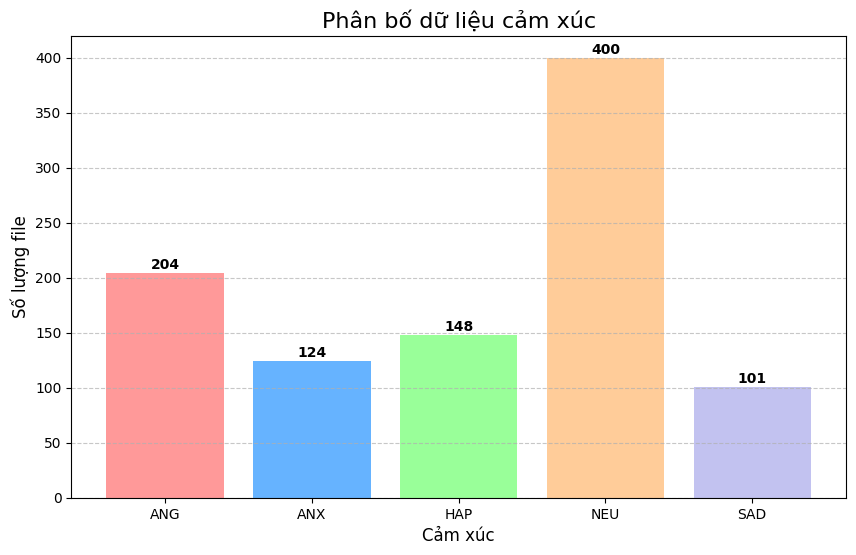

 Đã vẽ biểu đồ phân bố.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ===== CẤU HÌNH =====
project_root = os.path.dirname(os.getcwd())
preproc_dir = os.path.join(project_root, "pre_processing")
X_path = os.path.join(preproc_dir, "X_data.npy")
y_path = os.path.join(preproc_dir, "y_data.npy")

# ===== XỬ LÝ =====


# 1. Load dữ liệu
y_onehot = np.load(y_path)
classes = np.load(os.path.join(preproc_dir, "classes.npy"))

# 2. Giải mã One-hot về dạng số nguyên (Index)
# Ví dụ: [0, 0, 1, 0, 0] -> Index 2
y_indices = np.argmax(y_onehot, axis=1)

# 3. Đếm số lượng
unique, counts = np.unique(y_indices, return_counts=True)
stats = dict(zip(unique, counts))

total_samples = len(y_indices)

# ===== IN KẾT QUẢ =====
print("\n" + "="*40)
print(f"📊 BÁO CÁO THỐNG KÊ DỮ LIỆU ({total_samples} mẫu)")
print("="*40)
print(f"{'NHÃN (LABEL)':<15} | {'SỐ LƯỢNG':<10} | {'TỶ LỆ %':<10}")
print("-" * 40)

counts_list = [] # Để vẽ biểu đồ

for i, class_name in enumerate(classes):
    count = stats.get(i, 0) # Lấy số lượng, nếu không có thì bằng 0
    percent = (count / total_samples) * 100
    counts_list.append(count)
    
    print(f"{class_name:<15} | {count:<10} | {percent:.1f}%")

print("-" * 40)

# ===== VẼ BIỂU ĐỒ (Nếu chạy trên máy tính có màn hình) =====
try:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts_list, color=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
    
    # Viết số lên đầu cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontweight='bold')

    plt.title('Phân bố dữ liệu cảm xúc', fontsize=16)
    plt.xlabel('Cảm xúc', fontsize=12)
    plt.ylabel('Số lượng file', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print(" Đã vẽ biểu đồ phân bố.")
except Exception as e:
    print(" Không thể vẽ biểu đồ (có thể do môi trường dòng lệnh).")

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
import os
import sys

# Tắt log rác của Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ===== 1. LOAD DỮ LIỆU =====
print("⏳ Đang load dữ liệu...")

# Xác định đường dẫn đúng tới thư mục pre_processing (nằm cạnh TrainModel)
project_root = os.path.dirname(os.getcwd())
preproc_dir = os.path.join(project_root, "pre_processing")
X_path = os.path.join(preproc_dir, "X_data.npy")
y_path = os.path.join(preproc_dir, "y_data.npy")
classes_path = os.path.join(preproc_dir, "classes.npy")

missing = [p for p in [X_path, y_path, classes_path] if not os.path.exists(p)]
if missing:
    print("❌ LỖI: Không tìm thấy các file .npy sau:")
    for p in missing:
        print(f" - {p}")
    print("👉 Hãy đảm bảo notebook đang chạy từ thư mục TrainModel, và thư mục pre_processing nằm ở cùng cấp với TrainModel.")
    raise SystemExit(1)

# Load dữ liệu
X = np.load(X_path)
y = np.load(y_path)
classes = np.load(classes_path)

print(f"✅ Dữ liệu input: {X.shape}")  # (88, 130, 13)
print(f"✅ Số lớp cảm xúc: {len(classes)} {classes}")

# Chia tập Train (80%) và Test (20%)
# Vì dữ liệu ít (88 mẫu), ta để test_size nhỏ thôi để dành dữ liệu cho máy học
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 2. THIẾT KẾ MODEL (CNN 1D) =====
input_shape = (X.shape[1], X.shape[2])  # (130, 13)
num_classes = y.shape[1]

model = Sequential()

# Block 1
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Block 2
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Block 3
model.add(Conv1D(64, kernel_size=3, activation='relu'))  # Giảm filter chút vì data ít
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

# Fully Connected
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Dropout giúp giảm học vẹt
model.add(Dense(num_classes, activation='softmax'))  # Output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ===== 3. TRAINING =====
print("\n🚀 BẮT ĐẦU TRAIN...")
# Batch size nhỏ (8 hoặc 16) vì tổng dữ liệu chỉ có 88 mẫu
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

# ===== 4. ĐÁNH GIÁ =====
print("\n📊 ĐÁNH GIÁ KẾT QUẢ TRÊN TẬP TEST:")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🎯 Độ chính xác (Accuracy): {acc*100:.2f}%")

# Báo cáo chi tiết
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n--- CHI TIẾT TỪNG LỚP ---")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# ===== 5. LƯU MODEL =====
model_name = "emotion_model.keras"  # Đuôi mới của Keras là .keras (thay vì .h5)
model.save(model_name)
print(f"\n💾 Đã lưu model tại: {model_name}")
print("👉 Bây giờ bạn có thể dùng file này để dự đoán cảm xúc!")

⏳ Đang load dữ liệu...
✅ Dữ liệu input: (977, 130, 13)
✅ Số lớp cảm xúc: 5 ['ANG' 'ANX' 'HAP' 'NEU' 'SAD']


e:\anaconda3\envs\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 BẮT ĐẦU TRAIN...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3956 - loss: 1.6810 - val_accuracy: 0.4031 - val_loss: 2.5806
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5391 - loss: 1.1843 - val_accuracy: 0.4184 - val_loss: 2.1200
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6044 - loss: 0.9996 - val_accuracy: 0.4235 - val_loss: 2.1172
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6876 - loss: 0.8347 - val_accuracy: 0.4694 - val_loss: 1.5986
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7977 - loss: 0.6331 - val_accuracy: 0.5000 - val_loss: 1.5331
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8361 - loss: 0.4928 - val_accuracy: 0.4337 - val_loss: 1.5411
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8489 - loss: 0.4419 - val_accuracy: 0.4796 - val_loss: 1.6234
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8963 - loss: 0.3252 - val_accu

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import os

# ===== CẤU HÌNH =====
# Đường dẫn đến file audio bạn muốn thử
# Bạn có thể đổi tên file này thành file bất kỳ bạn muốn test
TEST_FILE = r"E:\KHMT\N4K2\DATN\data\raw_cuts_with_time_VNDC\0h01m55s_seg0022.wav" 

MODEL_PATH = "emotion_model.keras"
# Đảm bảo load đúng 'classes.npy' từ thư mục pre_processing (cùng cấp với TrainModel)
project_root = os.path.dirname(os.getcwd())
CLASSES_PATH = os.path.join(project_root, "pre_processing", "classes.npy")

SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# ===== HÀM XỬ LÝ (Phải giống hệt lúc train) =====
def extract_mfcc(file_path):
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        if len(signal) > SAMPLES_PER_TRACK:
            signal = signal[:SAMPLES_PER_TRACK]
        else:
            padding = int(SAMPLES_PER_TRACK - len(signal))
            signal = np.pad(signal, (0, padding), mode='constant')
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
        return mfcc.T
    except Exception as e:
        print(f"Lỗi đọc file: {e}")
        return None

# ===== CHƯƠNG TRÌNH DỰ ĐOÁN =====
# 1. Load Model và Nhãn
print("⏳ Đang load model...")
model = tf.keras.models.load_model(MODEL_PATH)
classes = np.load(CLASSES_PATH)
print(f"✅ Đã load model. Các nhãn AI biết: {classes}")

# 2. Xử lý file âm thanh
print(f"🎧 Đang nghe file: {os.path.basename(TEST_FILE)}")
mfcc = extract_mfcc(TEST_FILE)

if mfcc is not None:
    # Model cần input dạng (Số lượng, Thời gian, Đặc trưng) -> (1, 130, 13)
    mfcc = np.expand_dims(mfcc, axis=0) 

    # 3. Dự đoán
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction)
    predicted_label = classes[predicted_index]
    confidence = np.max(prediction) * 100 # Độ tin cậy

    print("\n" + "="*30)
    print(f"🤖 KẾT QUẢ DỰ ĐOÁN: {predicted_label}")
    print(f"🎯 Độ tin cậy: {confidence:.2f}%")
    print("="*30)
    
    # In ra xác suất của từng nhãn
    print("\nChi tiết xác suất:")
    for i, label in enumerate(classes):
        print(f"- {label}: {prediction[0][i]*100:.2f}%")

else:
    print("❌ Không xử lý được file âm thanh.")

ModuleNotFoundError: No module named 'librosa'